<a href="https://colab.research.google.com/github/Waidhoferj/CSC-566-Project/blob/main/FacialLandmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Landmarks
Experimentation with facial landmarks models and datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from google.colab import drive
import os
from scipy.io import loadmat
import random

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Add your name and filepath to the project folder so that you can load the datasets.


In [3]:
USER = "John"
USER_FILEPATHS = {
    "John" : "/content/drive/MyDrive/CSC 566 Project",
    "Jeremy" : "/content/drive/MyDrive/School/Undergrad/2021 Spring/CSC 566/CSC 566 Project",
    "Ty" : "/content/drive/MyDrive/CSC 566 Project"
}
PROJECT_FILEPATH = USER_FILEPATHS[USER]

## Data Preparation

In [4]:
# Sanity check for loading data
def display_landmarks(img, points):
  """
  Displays portrait with landmark dots drawn on the face.
  Assumes that points are in (68,2)
  """
  #If we are reading from .mat files directly (2,68)
  if points.shape[0] == 2:
    points = points.transpose(1,0)
  #If reading from model output
  elif len(points.shape) == 1:
    points = points.reshape(-1,2)
  fig,ax = plt.subplots(1)
  ax.set_aspect('equal')
  ax.imshow(img)
  for p in points:
      circ = Circle(p)
      ax.add_patch(circ)
  plt.show()

#points = loadmat(AFW_DATASET + "/70037463_1.mat")["pt2d"]
#img  = plt.imread( AFW_DATASET+"/70037463_1.jpg")

#display_landmarks(img,points)



In [5]:
import tensorflow as tf

DATALOADER_BASE_PATH = PROJECT_FILEPATH + "/datasets/tf-datasets"
USE_CROPPED_IMAGES = False
DATASET_PREFIX = "cropped-" if USE_CROPPED_IMAGES else ""

class DataLoader:

  IMAGE_SHAPE = (256, 256, 3) if USE_CROPPED_IMAGES else (450, 450, 3)
  LANDMARKS_SHAPE = (136,)

  BATCH_SIZE = 16
  TRAIN_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}train-{i}.tfrecord.gz" for i in range(5)]
  VAL_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}val-{i}.tfrecord.gz" for i in range(5)]
  TEST_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}test-{i}.tfrecord.gz" for i in range(5)]

  def load_datasets():
    dl = DataLoader()
    return (dl.__load_dataset(DataLoader.TRAIN_PATHS, DataLoader.BATCH_SIZE),
            dl.__load_dataset(DataLoader.VAL_PATHS, DataLoader.BATCH_SIZE),
            dl.__load_dataset(DataLoader.TEST_PATHS, 1))

  def __load_dataset(self, filepath, batch_size):
    dataset = tf.data.TFRecordDataset([filepath], compression_type="GZIP")
    dataset = dataset.map(self.__parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(self.__reshape_entry, num_parallel_calls=tf.data.AUTOTUNE)
    dataset.cache() # Cache the above map operations so they aren't re-run every epoch
    return dataset


  def __parse_example(self, record):
    feature_names = {}
    feature_names['image'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    feature_names['landmarks'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    return tf.io.parse_single_example(record, feature_names)

  def __reshape_entry(self, entry):
    image = tf.reshape(entry['image'], DataLoader.IMAGE_SHAPE)
    landmarks = tf.reshape(entry['landmarks'], DataLoader.LANDMARKS_SHAPE)
    return image, landmarks


train_data, val_data, test_data = DataLoader.load_datasets()


## Basic Benchmark Model
From [this medium article](https://towardsdatascience.com/detecting-facial-features-using-deep-learning-2e23c8660a7a)

In [6]:
def create_basic_landmark_model(input_shape, conv_range):
  input_layer = layers.Input(input_shape)
  x = input_layer
  for exp in conv_range:
    x = layers.Conv2D(2**exp, (3,3), 3, padding="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.MaxPooling2D(padding="same")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(500, activation="relu")(x)
  x = layers.Dense(90, activation="relu")(x)
  x = layers.Dense(68*2, activation="relu")(x)
  return Model(name="landmark_locator", inputs=input_layer, outputs=x)



In [7]:
INPUT_SHAPE = (450,450,3)
basic_model = create_basic_landmark_model(INPUT_SHAPE, range(5,8))
basic_model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
basic_model.summary()

Model: "landmark_locator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 450, 450, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)   

In [8]:
import time

SHOULD_TRAIN = True
save_model_path = os.path.join(PROJECT_FILEPATH, "models", f"Base-{int(time.time())}.h5")
if SHOULD_TRAIN:
  cp_filepath = os.path.join(PROJECT_FILEPATH, "models", "Base_Checkpoints")
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, save_best_only=True)
  basic_model.fit(train_data.batch(64), epochs=30, verbose=1, callbacks=[checkpoint])
  basic_model.save(save_model_path)
else:
  basic_model = tf.keras.models.load_model(save_model_path)


Epoch 1/30
26/26 [==============================] - 18s 582ms/step - loss: 0.2074 - accuracy: 0.0037
Epoch 2/30
26/26 [==============================] - 16s 627ms/step - loss: 0.0998 - accuracy: 0.0886
Epoch 3/30
26/26 [==============================] - 16s 626ms/step - loss: 0.0615 - accuracy: 0.0960
Epoch 4/30
26/26 [==============================] - 16s 623ms/step - loss: 0.0529 - accuracy: 0.1655
Epoch 5/30
26/26 [==============================] - 16s 624ms/step - loss: 0.0487 - accuracy: 0.2160
Epoch 6/30
26/26 [==============================] - 16s 628ms/step - loss: 0.0469 - accuracy: 0.2345
Epoch 7/30
26/26 [==============================] - 16s 620ms/step - loss: 0.0462 - accuracy: 0.2745
Epoch 8/30
26/26 [==============================] - 16s 622ms/step - loss: 0.0458 - accuracy: 0.2689
Epoch 9/30
26/26 [==============================] - 16s 629ms/step - loss: 0.0453 - accuracy: 0.2683
Epoch 10/30
26/26 [==============================] - 16s 629ms/step - loss: 0.0451 - accura

### Analyze Results

In [20]:
path = os.path.join(PROJECT_FILEPATH, "models", "Base.h5")
basic_model = tf.keras.models.load_model(path)
images = test_data.map(lambda x,y: x)
eval = basic_model.evaluate(images.batch(64))

11/11 [==============================] - 6s 546ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


In [10]:
basic_model.metrics_names

['loss', 'accuracy']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


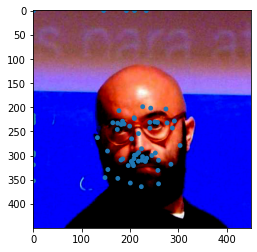

In [19]:
#@title View Predicted Images
image_index = 4 #@param {type:"slider", min:1, max:16, step:1}
points = predictions * 450
i = 0
for x in images:
  if (i == image_index):
    display_landmarks(tf.reshape(x, DataLoader.IMAGE_SHAPE), points[image_index])
    break
  i += 1